# Predict Sales

In [22]:
import pandas as pd
import numpy as np
import os
import s3fs
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

import pickle
import warnings
#import scikitplot as skplt

In [23]:
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

### Load Data

In [24]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [25]:
def load_train_test():
    BUCKET = "projet-bdc2324-team1/Generalization/sport"
    File_path_train = BUCKET + "/Train_set/" + "dataset_train5.csv"
    File_path_test = BUCKET + "/Test_set/" + "dataset_test5.csv"
    
    with fs.open( File_path_train, mode="rb") as file_in:
        dataset_train = pd.read_csv(file_in, sep=",")
        dataset_train['y_has_purchased'] = dataset_train['y_has_purchased'].fillna(0)

    with fs.open(File_path_test, mode="rb") as file_in:
        dataset_test = pd.read_csv(file_in, sep=",")
        dataset_test['y_has_purchased'] = dataset_test['y_has_purchased'].fillna(0)
    
    return dataset_train, dataset_test

In [26]:
def features_target_split(dataset_train, dataset_test):
    features_l = ['nb_tickets', 'nb_purchases', 'total_amount',
       'nb_suppliers', 'nb_tickets_internet',
       'opt_in',
        'nb_campaigns', 'nb_campaigns_opened']
    X_train = dataset_train[features_l]
    y_train = dataset_train[['y_has_purchased']]

    X_test = dataset_test[features_l]
    y_test = dataset_test[['y_has_purchased']]
    return X_train, X_test, y_train, y_test

In [27]:
dataset_train, dataset_test = load_train_test()

In [28]:
X_train, X_test, y_train, y_test = features_target_split(dataset_train, dataset_test)

In [29]:
print("Shape train : ", X_train.shape)
print("Shape test : ", X_test.shape)

Shape train :  (330117, 8)
Shape test :  (141480, 8)


### Prepare preprocessing and Hyperparameters

In [30]:
# Compute Weights
weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train['y_has_purchased']),
                                            y = y_train['y_has_purchased'])

weight_dict = {np.unique(y_train['y_has_purchased'])[i]: weights[i] for i in range(len(np.unique(y_train['y_has_purchased'])))}
weight_dict

{0.0: 0.5381774965030861, 1.0: 7.048360235716116}

In [31]:
numeric_features = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers',
                    'nb_tickets_internet', 'nb_campaigns', 'nb_campaigns_opened']

numeric_transformer = Pipeline(steps=[
    #("imputer", SimpleImputer(strategy="mean")),  
    ("scaler", StandardScaler()) 
])

categorical_features = ['opt_in']  

# Transformer for the categorical features
categorical_transformer = Pipeline(steps=[
    #("imputer", SimpleImputer(strategy="most_frequent")),  # Impute missing values with the most frequent
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preproc = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [32]:
# Set loss

balanced_scorer = make_scorer(balanced_accuracy_score)
recall_scorer = make_scorer(recall_score)

In [33]:
def draw_confusion_matrix(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


def draw_roc_curve(X_test, y_test):
    y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

    # Calcul des taux de faux positifs (FPR) et de vrais positifs (TPR)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
    
    # Calcul de l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize = (14, 8))
    plt.plot(fpr, tpr, label="ROC curve(area = %0.3f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="red",label="Random Baseline", linestyle="--")
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title('Courbe ROC : modèle logistique')
    plt.legend(loc="lower right")
    plt.show()

In [34]:
# Hyperparameter

param_grid = {'logreg__C': np.logspace(-10, 6, 17, base=2),
              'logreg__penalty': ['l1', 'l2'],
               'logreg__class_weight': ['balanced', weight_dict]} 

In [35]:
# Pipeline

pipeline = Pipeline(steps=[
    ('preprocessor', preproc),
    ('logreg', LogisticRegression(solver='saga', class_weight = weight_dict,
                                  max_iter=5000))  
])

pipeline.set_output(transform="pandas")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['nb_tickets', 'nb_purchases',
                                                   'total_amount',
                                                   'nb_suppliers',
                                                   'nb_tickets_internet',
                                                   'nb_campaigns',
                                                   'nb_campaigns_opened']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['opt_in'])])),
                ('logreg',
                 LogisticRegression(class_weight={0.0: 0.5381774965030861,
                                                  1.0: 7.048360235716116},
                                    max_iter=5000, solver='saga'))])

## Baseline

In [36]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['nb_tickets', 'nb_purchases',
                                                   'total_amount',
                                                   'nb_suppliers',
                                                   'nb_tickets_internet',
                                                   'nb_campaigns',
                                                   'nb_campaigns_opened']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['opt_in'])])),
                ('logreg',
                 LogisticRegression(class_weight={0.0: 0.5381774965030861,
                                                  1.0: 7.048360235716116},
                                    max_iter=5000, solver='saga'))])

In [37]:
y_pred = pipeline.predict(X_test)

# Calculate the F1 score
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {acc}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

recall = recall_score(y_test, y_pred)
print(f"Recall Score: {recall}")

Accuracy Score: 0.7563189143341815
F1 Score: 0.2737001769613213
Recall Score: 0.6419606680502026


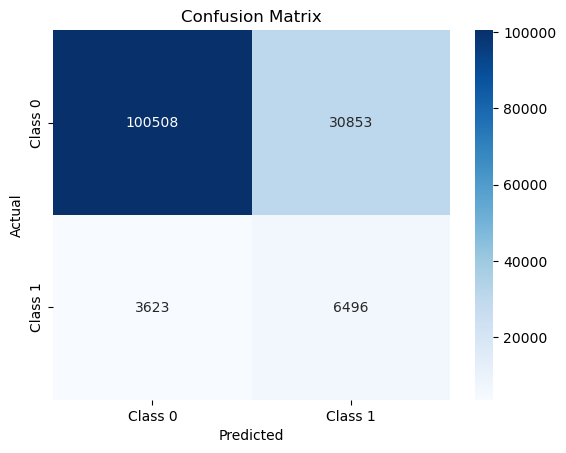

In [38]:
draw_confusion_matrix(y_test, y_pred)

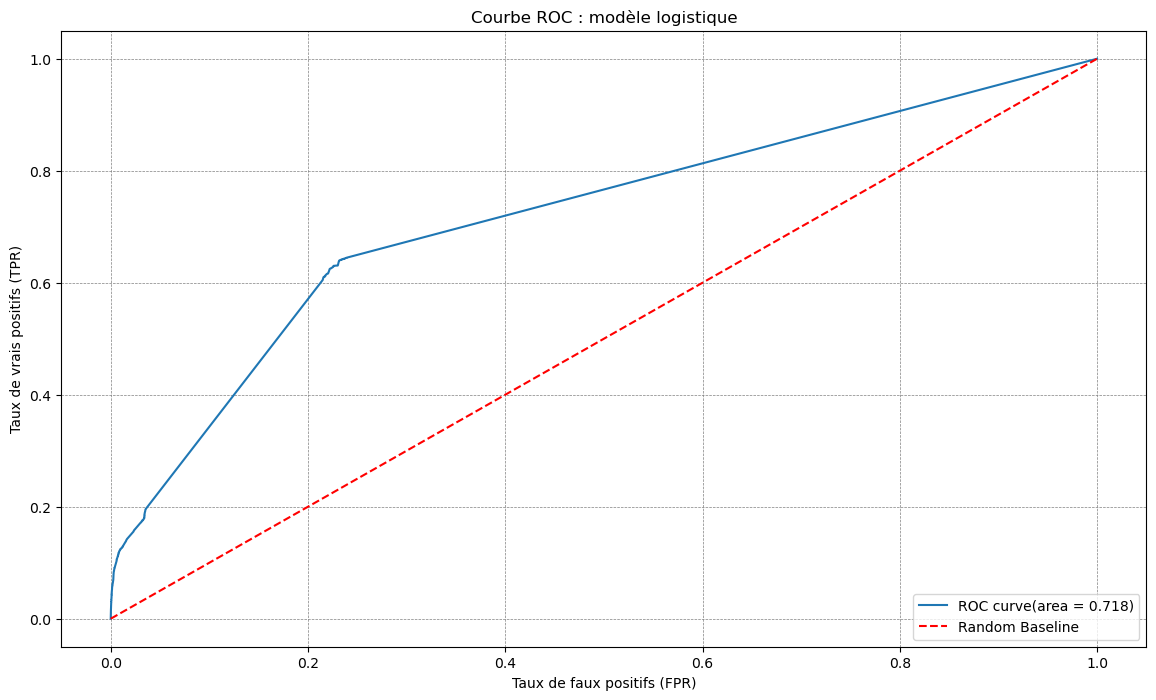

In [39]:
draw_roc_curve(X_test, y_test)

## Cross Validation

In [40]:
y_train = y_train['y_has_purchased']

In [41]:
# Cross validation

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=recall_scorer, error_score='raise',
                          n_jobs=-1)

grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
test_score = grid_search.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Best parameters found:  {'logreg__C': 0.0009765625, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l1'}
Best cross-validation score: 0.65
Test set score: 0.64


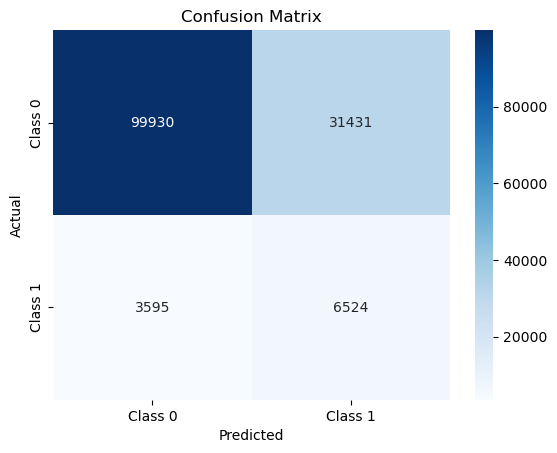

In [43]:
y_pred = grid_search.predict(X_test)

draw_confusion_matrix(y_test, y_pred)

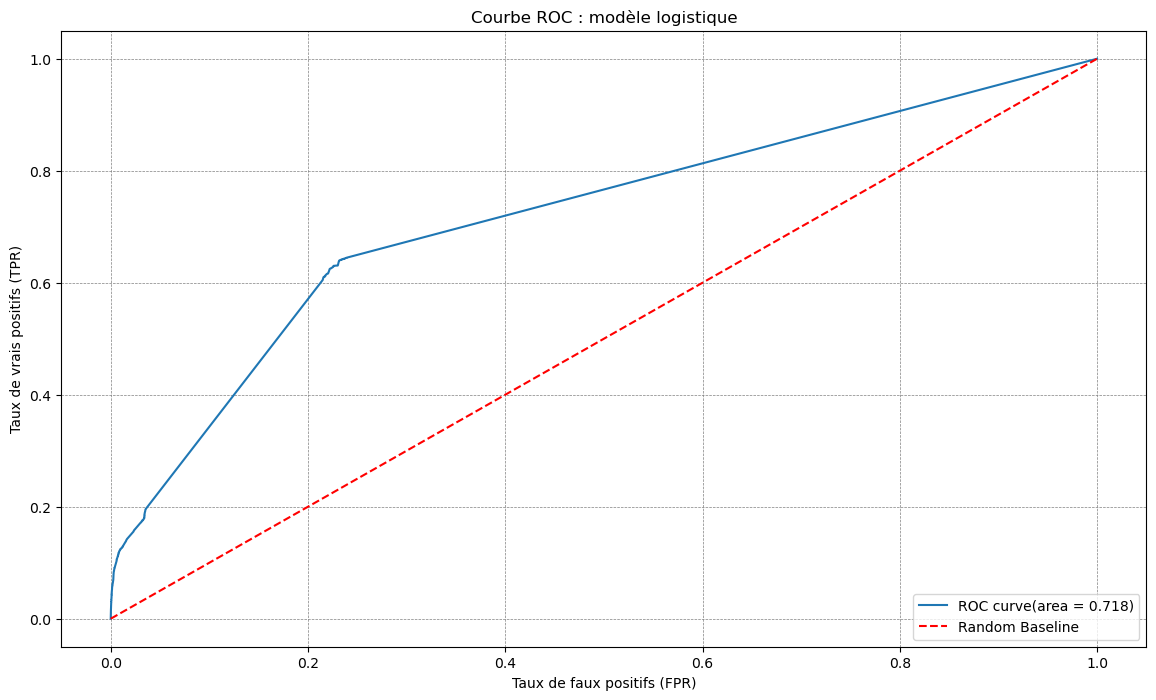

In [44]:
draw_roc_curve(X_test, y_test)